# Seasonal forecasts Wimbleball
This notebook loads the ECMWF seasonal forecast ensemble from 2000 to 2018 for the Wimbleball reservoir inflows and compares it to:

    1) Observed inflows: HBV model simulation using historical climate data
    2) Benchmark simulation: 
        - Ensemble Streamflow Prediction (ESP)
        - Systhetically generated weather
        - Climatology
        - Worst drought in records
    
The Continuos Ranked Probabilistic Skill Score (CRPSS) is applied to assess the skills of the seasonal forecast ensemble compared to the benchmark forecast.

In [1]:
# Work folder
folderpath='..//'

## Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import num2date, date2num
import datetime
import seaborn as sns
sns.set()
import ipywidgets as widgets

## Import sub-modules

In [3]:
from Submodules.Seasonal_forecast_v3 import Seasonal_forecast_v3 # Seasonal forecast data module
from Submodules.Observed_inflow_data import Observed_inflow_data
from Submodules.Climatology_data import Climatology_data
from Submodules.ESP_forecast import ESP_forecast
from Submodules.Forecast_SkillScores import CRPS_score, RPS_score, Brier_score, MyRPS_score, Mean_squared_error, Mean_error

In [4]:
# Excel date correction
day_num_corr = 2 # correction of the day number (since 01/01/1900) given by Excel
# font size
font_size = 14

#### Starting options

In [5]:
# Selection of the timestep
tstep = widgets.ToggleButtons(options=['daily', 'weekly', 'monthly'],description='Time step:',disabled=False,button_style='',
    layout=widgets.Layout(width='auto', height='auto',flex='4 1 100%'),tooltips=['Daily time step', 'Weekly time step', 'Monthly time step'])
# Selection of the seasonal forecast provider
forecast = widgets.ToggleButtons(options=['ECMWF', 'ESP', 'UKMO'],description='Forecast provider:',disabled=False,button_style='')
# Single or cumulative rainfall and streamflow values
cumul = widgets.ToggleButtons(options=['Single', 'Cumulative'],description='Single or cumulative rainfall/streamflow:',disabled=False,button_style='')
# Selection of the initial year
year0 = widgets.ToggleButtons(options=np.arange(2005,2017,1),description='Initial year:',disabled=False,button_style='')
# Selection of the initial month
month0 = widgets.ToggleButtons(options=np.arange(1,13,1),description='Initial month:',disabled=False,button_style='')
# Selection of the forecast lead time
horizon = widgets.ToggleButtons(options=np.arange(1,22,1),description='Lead time:',disabled=False,button_style='')
# Selection of the bias correction method
BC = widgets.ToggleButtons(options=['No BC', 'LS', 'QM'],description='Bias correction method:',disabled=False,button_style='',
    tooltips=['No bias correction', 'Linear scaling', 'Quantile mapping'])

benchmark = widgets.ToggleButtons(options=['climatology', 'ESP'],description='Skill score benchmark:',disabled=False,button_style='')

In [6]:
#widgets.DatePicker(description='Pick a Date',disabled=False)

In [7]:
display(tstep,forecast,cumul,BC,year0,month0,horizon,benchmark)

ToggleButtons(description='Time step:', layout=Layout(flex='4 1 100%', height='auto', width='auto'), options=(…

ToggleButtons(description='Forecast provider:', options=('ECMWF', 'ESP', 'UKMO'), value='ECMWF')

ToggleButtons(description='Single or cumulative rainfall/streamflow:', options=('Single', 'Cumulative'), value…

ToggleButtons(description='Bias correction method:', options=('No BC', 'LS', 'QM'), tooltips=('No bias correct…

ToggleButtons(description='Initial year:', options=(2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014…

ToggleButtons(description='Initial month:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1)

ToggleButtons(description='Lead time:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…

ToggleButtons(description='Skill score benchmark:', options=('climatology', 'ESP'), value='climatology')

## Data - Wimbleball

In [8]:
area_W = 28.8 # km2

### 1) Hydrological seasonal forecast (HBV simulation using daily rainfall, temperature and PET seasonal forecast members)
Using the previously calibrated HBV hydrological model and meteorological (ECMWF) seasonal rainfall, temperature and evaporation forecast ensemble (25 members) as forcing inputs, we obtain the inflow forecast ensemble. The warm-up period to estimate the IHCs starts at 01/01/1968.

In [9]:
if forecast.get_interact_value() == 'ECMWF' or forecast == 'UKMO':
    I_date, I_sf_ens,Rain_sf_ens,Temp_sf_ens,PET_sf_ens = Seasonal_forecast_v3(forecast.get_interact_value(),year0.get_interact_value(),month0.get_interact_value(),1,horizon.get_interact_value(),area_W,tstep.get_interact_value(),BC.get_interact_value())
    I_forec = I_sf_ens; Rain_forec = Rain_sf_ens

### 2) Ensemble Streamflow Prediction (ESP)
Historical sequences of climate data (precipitation, potential evapotranspiration, and/or temperature) at the time of forecast are used to force the HBV model, providing a plausible range of representations of the future streamflow states. The source of ESP skill is therefore due to initial hydrologic conditions (IHCs) from antecedent stores of soil moisture, groundwater, snowpack. The warm-up period to estimate the IHCs starts at 01/01/1968. 

In [10]:
I_date, I_ESP_ens,Rain_ESP_ens,Temp_ESP_ens,PET_ESP_ens = ESP_forecast(year0.get_interact_value(),month0.get_interact_value(),1,horizon.get_interact_value(),area_W,tstep.get_interact_value())
if benchmark.get_interact_value() == 'ESP':
    I_bench = I_ESP_ens; Rain_bench = Rain_ESP_ens; Temp_bench = Temp_ESP_ens; PET_bench = PET_ESP_ens
if forecast.get_interact_value() == 'ESP':
    I_forec = I_ESP_ens; Rain_forec = Rain_ESP_ens
ydays = np.zeros(len(I_date))
for i in range(len(I_date)):
    ydays[i] = int(I_date[i].timetuple().tm_yday)
ydays[np.where(ydays==366)]=365
I_day0 = I_date[0]
I_yday0 = I_day0.timetuple().tm_yday

### 3) Observed inflow data and climatology
HBV model simulation using historical climate data (raifall, temperature and PET). Available from 1968 to 2018.

In [11]:
Dates_obs, I_obs, Rain_obs, Temp_obs, PET_obs = Observed_inflow_data(year0.get_interact_value(),month0.get_interact_value(),1,horizon.get_interact_value(),area_W,tstep.get_interact_value())
# Historical inflow matrix
Rain_obs_mat,I_obs_mat = Climatology_data(area_W,tstep.get_interact_value(),1981,2016)[0:2]
# Historical weekly rain and inflow ensembles (from 1968 till year of study -1)
Rain_clim_ens = np.zeros([len(ydays),np.shape(Rain_obs_mat[:,Rain_obs_mat[0,:]<year0.get_interact_value()])[1]])
I_clim_ens = np.zeros([len(ydays),np.shape(I_obs_mat[:,I_obs_mat[0,:]<year0.get_interact_value()])[1]])
for i in range(len(ydays)):
    Rain_clim_ens[i,:] = Rain_obs_mat[int(ydays[i]),Rain_obs_mat[0,:]<year0.get_interact_value()]
    I_clim_ens[i,:] = I_obs_mat[int(ydays[i]),I_obs_mat[0,:]<year0.get_interact_value()]
Rain_clim_ens[0,:] = 0 # The day 0 is not taken into account
I_clim_ens[0,:] = 0 # The day 0 is not taken into account
if benchmark.get_interact_value() == 'climatology':
    I_bench = I_clim_ens; Rain_bench = Rain_clim_ens

### 4) Non-bias-corrected hydrological seasonal forecast 

In [12]:
I_nbcsf_date, I_nbcsf_ens,Rain_nbcsf_ens,Temp_nbcsf_ens_w,PET_nbcsf_ens_w = Seasonal_forecast_v3('ECMWF',year0.get_interact_value(),month0.get_interact_value(),1,horizon.get_interact_value(),area_W,tstep.get_interact_value(),'No BC')

## Cumulative precipitation and inflows

In [13]:
if cumul.get_interact_value() == 'Cumulative':
    I_obs = np.cumsum(I_obs)
    I_forec = np.cumsum(I_forec,axis = 0)
    I_bench = np.cumsum(I_bench,axis = 0)

    Rain_obs = np.cumsum(Rain_obs)
    Rain_forec = np.cumsum(Rain_forec,axis = 0)
    Rain_bench = np.cumsum(Rain_bench,axis = 0)

## ESP vs Meteorological seasonal forecast
The ESP forecast inflow ensemble (number of members = year of study - 1968) is compared to the ECMWF seasonal forecast inflow ensemble (number of members = 25).

## Forecast skill scores
### RPSS
We used the Ranked Probabilistic Skill Score (RPSS) to assess how skillfull the forecast system is. It tells us how much better the forecast is at predicting the observed inflow compared to a benchmark (here HBV model simulation using historical climate data).

Similar to the mean squared error (mse), the Ranked Probabilistic Skill (RPS) is a quadratic measure, and thus larger deviations from the actual probability are penalized much stronger than smaller ones. The RPS is defined as:

\begin{equation*}
RPS = 1/N \sum_{k=1}^N RPS_k
\end{equation*}

where N is the number of forecast members, k is the forecast index, and

\begin{equation*}
RPS_k = \sum_{j=1}^J |I_j - O_j|^2
\end{equation*}

Here $J$ denotes the number of the classes and $Y_j$ and $O_j$ are the cumulative probabilities of the forecasts. The RPS is zero in case of a perfect forecast and positive otherwise. 

The calculation of the skill score is based on the comparison of the forecast score ($RPS_{F}$) to a benchmark forecast score ($RPS_{B}$). Thus the RPSS becomes:

\begin{equation*}
RPSS = 1 - \frac{\sum_{k=1}^N RPS_{F,k}} {\sum_{k=1}^N RPS_{B,k}}
\end{equation*}

The degree of skill estimated by RPSS is based on: very high (0.75-1), high (0.5-0.75), moderate (0.25-0.5), low (0-0.25), no skill (0) and negative skill meaning that climatology is better predictor of what is going to happen than the forecast).

In [14]:
I_RPS_F,I_RPS_B,I_RPSS,I_RPS_F_t,I_RPS_B_t,I_RPSS_t = RPS_score(I_obs,I_forec,I_bench)
Rain_RPS_F,Rain_RPS_B,Rain_RPSS,Rain_RPS_F_t,Rain_RPS_B_t,Rain_RPSS_t = RPS_score(Rain_obs,Rain_forec,Rain_bench)     

### CRPSS

In [15]:
I_CRPS_F,I_CRPS_B,I_CRPSS,I_CRPS_F_t,I_CRPS_B_t,I_CRPSS_t = CRPS_score(I_obs,I_forec,I_bench)
Rain_CRPS_F,Rain_CRPS_B,Rain_CRPSS,Rain_CRPS_F_t,Rain_CRPS_B_t,Rain_CRPSS_t = CRPS_score(Rain_obs,Rain_forec,Rain_bench)

C:\Users\ap18525\Google Drive\AndresFrancesca\mat\For Chris\Reservoir operation\Submodules\Forecast_SkillScores.py:24: RuntimeWarning: invalid value encountered in true_divide
  CRPSS_t = 1 - (CRPS_F_t/CRPS_B_t)


### Brier score and Reliability, Resolution and Uncertainty
A reliable forecast has REL = 0, and any violations of reliability lead to REL > 0. 

If the conditional event frequencies are the same for all categories, the different forecast values cannot distinguish events that are more or less likely than average; such an ‘uninformed’ forecast has RES = 0. 
If conditional event frequencies are different for different forecast values, the forecast has RES > 0.

In [16]:
I_Brier_F,I_Brier_B,I_Brier, I_Relia, I_Resol, I_Uncer = Brier_score(I_obs,I_forec,I_bench)
Rain_Brier_F,Rain_Brier_B,Rain_Brier, Rain_Relia, Rain_Resol, Rain_Uncer = Brier_score(Rain_obs,Rain_forec,Rain_bench)        

C:\Users\ap18525\Google Drive\AndresFrancesca\mat\For Chris\Reservoir operation\Submodules\Forecast_SkillScores.py:293: RuntimeWarning: invalid value encountered in true_divide
  Brier = 1 - (Brier_F/Brier_B) # Brier score for each class/category (i)


### My RPSS
The difference between CDF is neither squared nor calculated in absolute value

In [17]:
I_MyRPS_F,I_MyRPS_B,I_MyRPSS,I_MyRPS_F_t,I_MyRPS_B_t,I_MyRPSS_t = MyRPS_score(I_obs,I_forec,I_bench)
Rain_MyRPS_F,Rain_MyRPS_B,Rain_MyRPSS,Rain_MyRPS_F_t,Rain_MyRPS_B_t,Rain_MyRPSS_t = MyRPS_score(Rain_obs,Rain_forec,Rain_bench)  

### Mean squared error

In [18]:
I_MSE_F,I_MSE_B,I_MSE,I_MSE_F_t,I_MSE_B_t,I_MSE_t = Mean_squared_error(I_obs,I_forec,I_bench)
Rain_MSE_F,Rain_MSE_B,Rain_MSE,Rain_MSE_F_t,Rain_MSE_B_t,Rain_MSE_t = Mean_squared_error(Rain_obs,Rain_forec,Rain_bench)        

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


### Mean error

In [19]:
I_ME_F,I_ME_B,I_ME,I_ME_F_t,I_ME_B_t,I_ME_t = Mean_error(I_obs,I_forec,I_bench)
Rain_ME_F,Rain_ME_B,Rain_ME,Rain_ME_F_t,Rain_ME_B_t,Rain_ME_t = Mean_error(Rain_obs,Rain_forec,Rain_bench)        

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


#### Rainfall - Forecast vs Benchmark

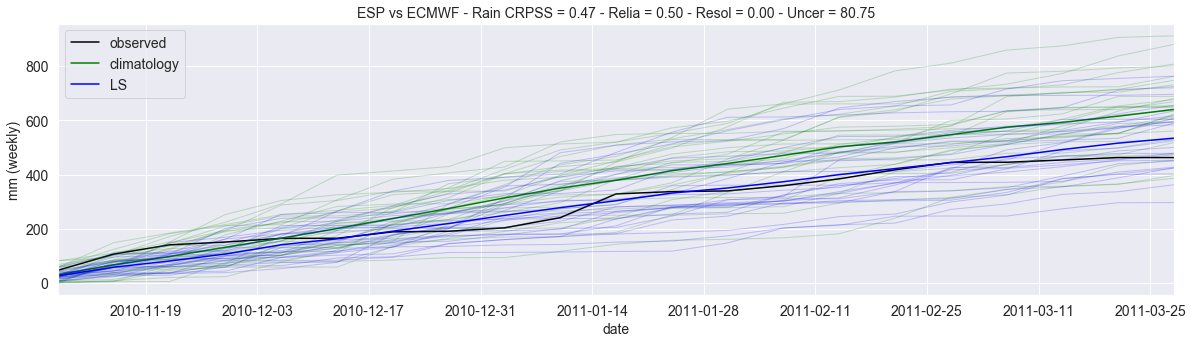

In [20]:
# Plot
fig,ax = plt.subplots(figsize=(20, 5))
# Observed rainfall
ax.plot(I_date,Rain_obs,label = "observed",color = 'black')
# Benchmark forecast (climatology)
ax.plot(np.array(I_date),Rain_bench,color = 'green',linewidth = 1,alpha = 0.2)
ax.plot(np.array(I_date),np.mean(Rain_bench,axis=1),color = 'green',label = benchmark.get_interact_value())
# Seasonal forecast ensemble
ax.plot(np.array(I_date),Rain_forec,linewidth = 1,color = 'blue',alpha = 0.2)
ax.plot(np.array(I_date),np.mean(Rain_forec,axis=1),color = 'blue',label = BC.get_interact_value())
ax.legend(fontsize=font_size)
ax.set_xlabel("date",fontsize=font_size)
ax.set_ylabel('mm ('+tstep.get_interact_value()+')',fontsize=font_size)
#ax.set_xticks([I_date[1],I_date[2],I_date[3],I_date[4],I_date[5]])
#ax.set_xticklabels([I_date[0].strftime("%B"),I_date[1].strftime("%B"),I_date[2].strftime("%B"),I_date[3].strftime("%B"),I_date[4].strftime("%B")])
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(font_size)
ax.set_xlim(I_date[1],I_date[-1])
ax.set_title(benchmark.get_interact_value()+' vs ECMWF - Rain CRPSS = '+str("{0:.2f}".format(Rain_CRPSS))+
    ' - Relia = '+str("{0:.2f}".format(np.sum(Rain_Relia)))+
    ' - Resol = '+str("{0:.2f}".format(np.sum(Rain_Resol)))+
    ' - Uncer = '+str("{0:.2f}".format(np.sum(Rain_Uncer))),fontsize=font_size)
plt.show()

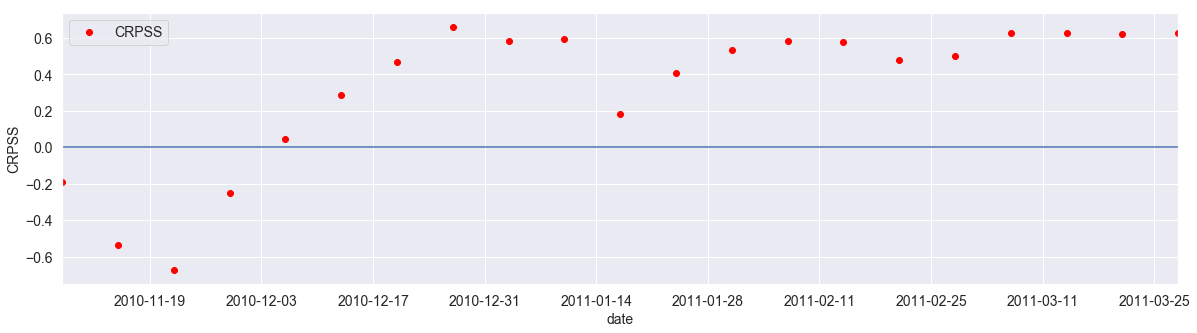

In [22]:
# Plot weekly CRPSS
fig,ax = plt.subplots(figsize=(20, 5))
ax.scatter(I_date,Rain_CRPSS_t,label = "CRPSS",color = 'red')
ax.axhline(0)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(font_size)
ax.legend(fontsize=font_size)
ax.set_xlabel("date",fontsize=font_size)
ax.set_ylabel("CRPSS",fontsize=font_size)
#ax.set_xticks([I_sf_date_w[0],I_sf_date_w[5],I_sf_date_w[9],I_sf_date_w[13],I_sf_date_w[17],I_sf_date_w[21]])
ax.set_xlim(I_date[1],I_date[-1])
plt.show()

#### Streamflow -  Forecast vs Benchmark

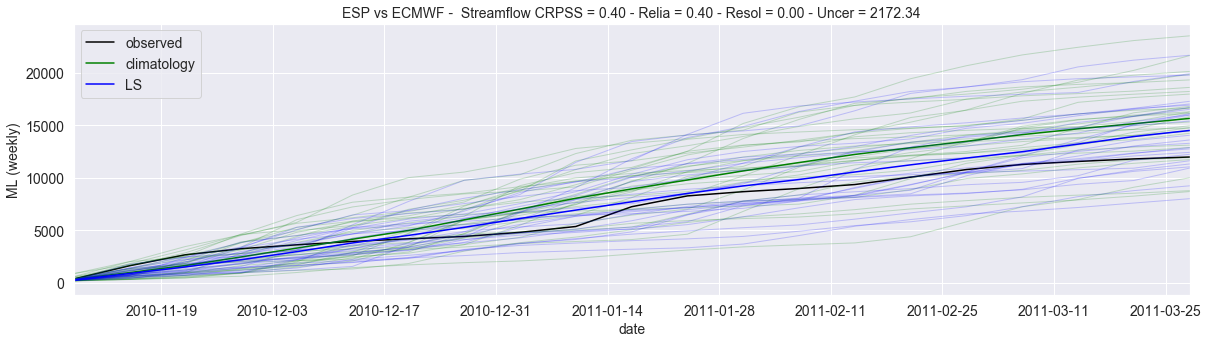

In [23]:
# Plot 2
fig,ax = plt.subplots(figsize=(20, 5))
# Observed inflow
ax.plot(I_date,I_obs,label = "observed",color = 'black')
# Benchmark forecast (climatology)
ax.plot(np.array(I_date),I_bench,color = 'green',linewidth = 1,alpha = 0.2)
ax.plot(np.array(I_date),np.mean(I_bench,axis=1),color = 'green',label = benchmark.get_interact_value())
# Seasonal forecast ensemble
ax.plot(np.array(I_date),I_forec,linewidth = 1,color = 'blue',alpha = 0.2)
ax.plot(np.array(I_date),np.mean(I_forec,axis=1),color = 'blue',label = BC.get_interact_value())
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(font_size)
ax.legend(fontsize=font_size)
ax.set_xlabel("date",fontsize=font_size)
ax.set_ylabel('ML ('+tstep.get_interact_value()+')',fontsize=font_size)
ax.set_xlim(I_date[1],I_date[-1])
#ax.set_xticks([I_sf_date_w[1],I_sf_date_w[5],I_sf_date_w[9],I_sf_date_w[13],I_sf_date_w[17],I_sf_date_w[21]])
ax.set_title(benchmark.get_interact_value()+' vs ECMWF -  Streamflow CRPSS = '+str("{0:.2f}".format(I_CRPSS))+
    ' - Relia = '+str("{0:.2f}".format(np.sum(I_Relia)))+
    ' - Resol = '+str("{0:.2f}".format(np.sum(I_Resol)))+
    ' - Uncer = '+str("{0:.2f}".format(np.sum(I_Uncer))),fontsize=font_size)
plt.show()
plt.show()

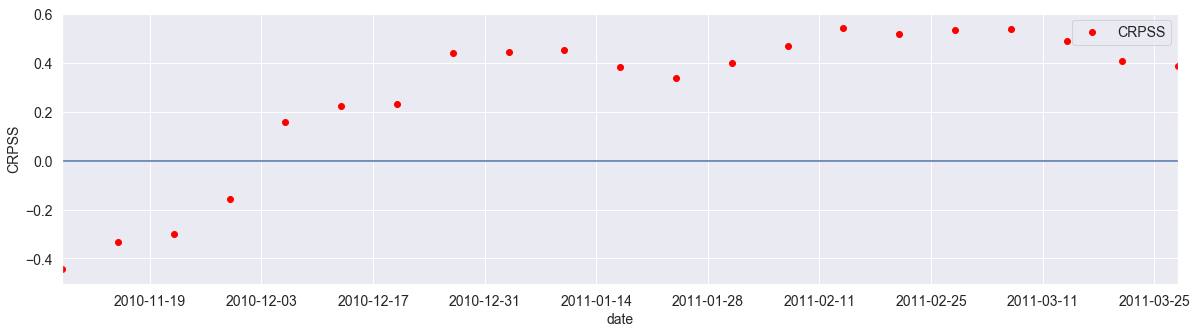

In [24]:
# Plot weekly CRPSS
fig,ax = plt.subplots(figsize=(20, 5))
ax.scatter(I_date,I_CRPSS_t,label = "CRPSS",color = 'red')
ax.axhline(0)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(font_size)
ax.legend(fontsize=font_size)
ax.set_xlabel("date",fontsize=font_size)
ax.set_ylabel("CRPSS",fontsize=font_size)
#ax.set_xticks([I_sf_date_w[0],I_sf_date_w[5],I_sf_date_w[9],I_sf_date_w[13],I_sf_date_w[17],I_sf_date_w[21]])
ax.set_xlim(I_date[1],I_date[-1])
plt.show()